fix timestamps
end of fixing timestamps


Segmenting: 100%|██████████| 250/250 [00:07<00:00, 32.76it/s]


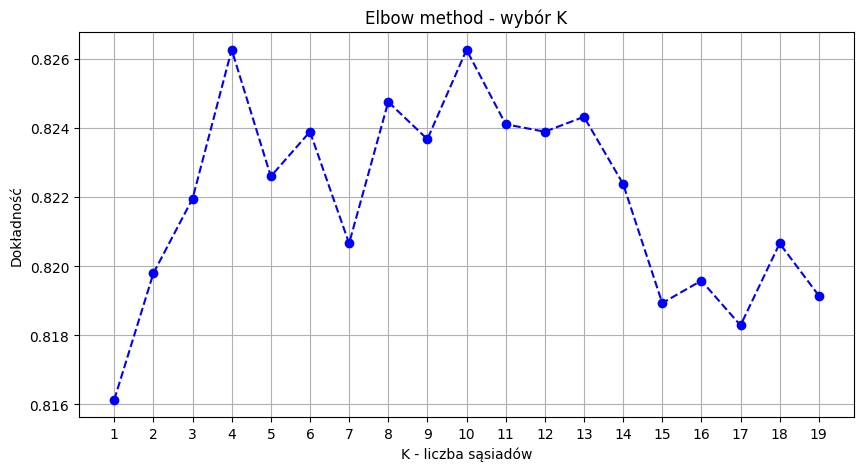

In [2]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from data_loader.data_loader import TimeWindowSegmenter
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# inicjalizacja procesora danych
data_processor = TimeWindowSegmenter(
  df_path="wsidm.parquet",
  window_size=10,   # 10 sekund
  step_size=10,     # 10 sekund - ramki się nie pokrywają w danych
)

# ekstrakcja cech
def extract_features(window_df):
    features = []
    for col in ['g_x', 'g_y', 'g_z', 'ac_x', 'ac_y', 'ac_z']:
        col_data = window_df[col]
        features.append(col_data.mean())
        features.append(col_data.std())
        features.append(col_data.min())
        features.append(col_data.max())
    return features

# generowanie etykiet
X = []
y = []

for window in data_processor.segment():
    feats = extract_features(window)
    label = window[data_processor.activity_column].iloc[0]
    X.append(feats)
    y.append(label)

X = np.array(X)
y = np.array(y)

# normalizacja
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# cross-validation dla stabilizacji wyników
k_values = list(range(1, 20))
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    
    cv_accuracies = cross_val_score(knn, X_scaled, y, cv=5, scoring='accuracy')
    
    accuracies.append(cv_accuracies.mean())

# rysowanie wykresu
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='dashed', color='b')
plt.xlabel("K - liczba sąsiadów")
plt.ylabel("Dokładność")
plt.title("Elbow method - wybór K")
plt.xticks(k_values)
plt.grid()
plt.show()
